In [3]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time
from itertools import combinations
import math

In [4]:
def parse_benchmark(filename):
    with open(filename, 'r') as file:
        lines = [line.strip() for line in file if line.strip()]  # Read non-empty lines
    
    # Read universe size (m) and number of subsets (n)
    universe_size, num_subsets = map(int, lines[0].split())
    universe = set(range(1, universe_size + 1))
    
    # Initialize empty subsets (indices 0 to num_subsets-1)
    subsets = [set() for _ in range(num_subsets)]
    
    current_element = 1  # Elements start at 1
    line_index = 1       # Start reading from line 1 (after m, n)
    
    while line_index < len(lines) and current_element <= universe_size:
        # Read the number of subsets containing current_element
        num_subsets_containing = int(lines[line_index])
        line_index += 1
        
        # Read all subset indices (may span multiple lines)
        subset_indices = []
        subset_indices_read = 0
        
        while (line_index < len(lines) and (subset_indices_read < num_subsets_containing)) : 
            # Split the line into integers
            parts = list(map(int, lines[line_index].split()))
            
            # Add them to subset_indices
            subset_indices.extend(parts)
            subset_indices_read += len(parts)
            
            # Move to next line
            line_index += 1
        
        # Assign current_element to each subset in subset_indices
        for subset_idx in subset_indices:
            if 1 <= subset_idx <= num_subsets:
                subsets[subset_idx - 1].add(current_element)
        
        current_element += 1  # Move to next element
    
    return universe, subsets

# Example usage
universe, subsets = parse_benchmark("Problem_set_a/scpa1.txt")
print(f"Universe size: {len(universe)}")
print(f"Number of subsets: {len(subsets)}")
print("\nFirst 5 subsets:")
for i, subset in enumerate(subsets[:5], 1):
    print(f"Subset {i}: {subset}") 

Universe size: 300
Number of subsets: 3000

First 5 subsets:
Subset 1: {292, 38, 167, 105, 75, 236, 300, 271, 53, 248, 190, 159}
Subset 2: {289, 195, 200, 297, 299, 238, 208, 17, 60, 159}
Subset 3: {1, 162, 257, 42, 123, 269, 90, 27, 28, 189}
Subset 4: {129, 193, 67, 200, 139, 176, 17, 55, 123}
Subset 5: {64, 233, 170, 251, 16, 25, 219, 95}


Max Covering Probelm Class 

In [5]:
class MaximumCoveringProblem:
    def __init__(self, U, S, k):
        """
        Initialize the Maximum Covering Problem
        :param U: Universe of elements (list)
        :param S: Collection of subsets (list of lists)
        :param k: Number of subsets to select (int)
        """
        self.U = U
        self.S = S
        self.k = k
        self.n = len(U)  # Number of elements in universe
        self.m = len(S)   # Number of subsets
        
        # Create a mapping from element to subsets that contain it
        self.element_to_subsets = defaultdict(list)
        for i, subset in enumerate(S):
            for elem in subset:
                self.element_to_subsets[elem].append(i)
        
        # For DFS comparison
        self.best_dfs_solution = None
        self.best_dfs_coverage = 0
    
    def evaluate(self, solution):
        """
        Evaluate a solution (binary vector) by counting the number of unique elements covered
        :param solution: Binary vector representing selected subsets
        :return: Number of covered elements
        """
        selected_subsets = [self.S[i] for i in range(self.m) if solution[i] == 1]
        covered = set()
        for subset in selected_subsets:
            covered.update(subset)
        return len(covered)
    
    def is_valid(self, solution):
        """Check if solution has exactly k subsets selected"""
        return sum(solution) == self.k
    
    def generate_random_solution(self):
        """Generate a random valid solution (exactly k subsets selected)"""
        solution = [0] * self.m
        indices = random.sample(range(self.m), self.k)
        for idx in indices:
            solution[idx] = 1
        return solution
    
    def solve_with_DFS(self, max_time=60):
        """Exact solution using Depth-First Search (for comparison)"""
        self.best_dfs_solution = None
        self.best_dfs_coverage = 0
        start_time = time()
        
        # We'll use combinations to generate all possible k-subset selections
        for combo in combinations(range(self.m), self.k):
            if time() - start_time > max_time:
                break  # Timeout
            coverage = len(set().union(*[self.S[i] for i in combo]))
            if coverage > self.best_dfs_coverage:
                self.best_dfs_coverage = coverage
                self.best_dfs_solution = combo
        
        # Convert to binary solution format
        if self.best_dfs_solution:
            solution = [0] * self.m
            for idx in self.best_dfs_solution:
                solution[idx] = 1
            return solution, self.best_dfs_coverage
        return None, 0


DiscretePSO

In [4]:
class DiscretePSO:
    def __init__(self, problem, num_particles=50, max_iter=100, w=0.8, c1=2.05, c2=2.05):
        """
        Initialize the Discrete PSO solver
        :param problem: MaximumCoveringProblem instance
        :param num_particles: Number of particles in the swarm
        :param max_iter: Maximum number of iterations
        :param w: Inertia weight
        :param c1: Cognitive coefficient
        :param c2: Social coefficient
        """
        self.problem = problem
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
        # Initialize particles
        self.particles = []
        for _ in range(num_particles):
            # Random continuous position in [0,1]^m
            position = np.random.rand(problem.m)
            # Convert to valid binary solution
            binary_solution = self._discretize(position)
            # Random velocity
            velocity = np.random.randn(problem.m) * 0.1
            
            fitness = problem.evaluate(binary_solution)
            
            # Personal best
            pbest = {
                'position': position.copy(),
                'binary_solution': binary_solution.copy(),
                'fitness': fitness
            }
            
            self.particles.append({
                'position': position,
                'velocity': velocity,
                'binary_solution': binary_solution,
                'fitness': fitness,
                'pbest': pbest
            })
        
        # Global best
        self.gbest = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest'].copy()
    
    def _discretize(self, continuous_position):
        """Convert continuous position to binary solution with exactly k 1's"""
        # Get indices of top k values
        top_k_indices = np.argpartition(continuous_position, -self.problem.k)[-self.problem.k:]
        binary_solution = [0] * self.problem.m
        for idx in top_k_indices:
            binary_solution[idx] = 1
        return binary_solution
    
    def optimize(self):
        """Run the PSO optimization"""
        convergence_curve = []
        best_fitness_history = []
        
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Update velocity
                r1, r2 = np.random.rand(2)
                cognitive = self.c1 * r1 * (particle['pbest']['position'] - particle['position'])
                social = self.c2 * r2 * (self.gbest['position'] - particle['position'])
                particle['velocity'] = self.w * particle['velocity'] + cognitive + social
                
                # Update position
                particle['position'] = particle['position'] + particle['velocity']
                # Clip to [0,1] range
                particle['position'] = np.clip(particle['position'], 0, 1)
                
                # Discretize to binary solution
                particle['binary_solution'] = self._discretize(particle['position'])
                particle['fitness'] = self.problem.evaluate(particle['binary_solution'])
                
                # Update personal best
                if particle['fitness'] > particle['pbest']['fitness']:
                    particle['pbest']['position'] = particle['position'].copy()
                    particle['pbest']['binary_solution'] = particle['binary_solution'].copy()
                    particle['pbest']['fitness'] = particle['fitness']
            
            # Update global best
            current_best = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest']
            if current_best['fitness'] > self.gbest['fitness']:
                self.gbest = current_best.copy()
            
            convergence_curve.append(self.gbest['fitness'])
            best_fitness_history.append(self.gbest['fitness'])
            
            # Early stopping if optimal solution found
            if self.gbest['fitness'] == self.problem.n:
                break
        
        return self.gbest, convergence_curve


In [6]:
import numpy as np

class DiscretePSOpso:
    def __init__(self, problem, num_particles=100, max_iter=500, w=0.8, c1=2.05, c2=2.05):
        """
        Initialize the Discrete PSO solver
        :param problem: MaximumCoveringProblem instance
        :param num_particles: Number of particles in the swarm
        :param max_iter: Maximum number of iterations
        :param w: Inertia weight
        :param c1: Cognitive coefficient
        :param c2: Social coefficient
        """
        self.problem = problem
        self.num_particles = num_particles
        self.max_iter = max_iter
        self.w = w
        self.c1 = c1
        self.c2 = c2
        
        # Initialize particles
        self.particles = []
        for _ in range(num_particles):
            # Random continuous position in [0,1]^m
            position = np.random.rand(problem.m)
            # Convert to valid binary solution
            binary_solution = self._discretize(position)
            # Random velocity (initialize small values)
            velocity = np.random.uniform(-1, 1, problem.m) * 0.1
            
            fitness = problem.evaluate(binary_solution)
            
            # Personal best
            pbest = {
                'position': position.copy(),
                'binary_solution': binary_solution.copy(),
                'fitness': fitness
            }
            
            self.particles.append({
                'position': position,
                'velocity': velocity,
                'binary_solution': binary_solution,
                'fitness': fitness,
                'pbest': pbest
            })
        
        # Global best
        self.gbest = max(self.particles, key=lambda x: x['pbest']['fitness'])['pbest'].copy()
    
    def _discretize(self, continuous_position):
        """Convert continuous position to binary solution with exactly k 1's"""
        # Get indices of top k values
        sorted_indices = np.argsort(-continuous_position)  # Sort descending
        top_k_indices = sorted_indices[:self.problem.k]  # Pick top k elements
        binary_solution = [0] * self.problem.m
        for idx in top_k_indices:
            binary_solution[idx] = 1
        return binary_solution
    
    def _update_velocity(self, particle):
        """Update velocity with discrete PSO logic"""
        r1, r2 = np.random.rand(2)
        cognitive = self.c1 * r1 * (particle['pbest']['position'] - particle['position'])
        social = self.c2 * r2 * (self.gbest['position'] - particle['position'])
        
        new_velocity = self.w * particle['velocity'] + cognitive + social
        return np.clip(new_velocity, -1, 1)  # Keep velocity within reasonable bounds
    
    def _sigmoid(self, x):
        """Sigmoid function to convert velocity into probability"""
        return 1 / (1 + np.exp(-x))
    
    def optimize(self):
        """Run the PSO optimization"""
        convergence_curve = []
        best_fitness_history = []
        
        for iteration in range(self.max_iter):
            for particle in self.particles:
                # Update velocity
                particle['velocity'] = self._update_velocity(particle)
                
                # Convert velocity to probability using sigmoid
                prob = self._sigmoid(particle['velocity'])
                
                # Update position using probability thresholding
                new_position = np.random.rand(self.problem.m) < prob  # Binary selection
                particle['position'] = new_position.astype(float)
                
                # Discretize to ensure exactly k elements are selected
                particle['binary_solution'] = self._discretize(particle['position'])
                particle['fitness'] = self.problem.evaluate(particle['binary_solution'])
                
                # Update personal best
                if particle['fitness'] > particle['pbest']['fitness']:
                    particle['pbest']['position'] = particle['position'].copy()
                    particle['pbest']['binary_solution'] = particle['binary_solution'].copy()
                    particle['pbest']['fitness'] = particle['fitness']
            
            # Update global best
            best_particle = max(self.particles, key=lambda x: x['pbest']['fitness'])
            if best_particle['pbest']['fitness'] > self.gbest['fitness']:
                self.gbest = best_particle['pbest'].copy()
            
            convergence_curve.append(self.gbest['fitness'])
            best_fitness_history.append(self.gbest['fitness'])
            
            # Early stopping if optimal solution found
            if self.gbest['fitness'] == self.problem.n:
                break
        
        return self.gbest, convergence_curve

In [11]:
universe, subsets = parse_benchmark("Problem_set_c/scpc1.txt")
problem = MaximumCoveringProblem(universe, subsets, k=50)  # Example

pso = DiscretePSOpso(problem, num_particles=80, max_iter=100)
best_solution, convergence_curve = pso.optimize()
print("Best solution found:", best_solution['binary_solution'])
print("Best fitness:", best_solution['fitness'])

Best solution found: [1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [9]:
pso1=DiscretePSO(problem, num_particles=80, max_iter=100)
best_solution1, convergence_curve1 = pso1.optimize()
print("Best solution found:", best_solution1['binary_solution'])
print("Best fitness:", best_solution1['fitness'])

Best solution found: [0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [44]:
universe, subsets = parse_benchmark("Problem_set_a/scpa1.txt")
k =  len(subsets)//200
print(len(subsets))
print(k)

3000
15


In [119]:
def parameter_tuning_experiment(universetest , subsettest , num ,k):
    """Experiment to tune PSO parameters"""
    # Fixed problem instance

    
   
    problem = MaximumCoveringProblem(universetest, subsettest, k)
    print(f"Problem instance loaded: {len(universetest)} elements, {len(subsettest)} subsets")
    print(f"Selecting k = {k} subsets")
    # Parameter combinations to try
    param_combinations = [
        {'w': 0.4, 'c1': 1.0, 'c2': 1.0},
        {'w': 0.4, 'c1': 2.0, 'c2': 2.0},
        {'w': 0.4, 'c1': 1.0, 'c2': 2.0},
        {'w': 0.4, 'c1': 2.0, 'c2': 1.0},
        {'w': 0.95, 'c1': 2.0, 'c2': 2.0},
        {'w': 0.95, 'c1': 2.0, 'c2': 1.0},
        {'w': 0.95, 'c1': 1.0, 'c2': 2.0},
        {'w': 0.95, 'c1': 1.0, 'c2': 1.0},
        {'w': 0.8, 'c1': 2.0, 'c2': 2.0},
        {'w': 0.8, 'c1': 2.0, 'c2': 1.0},
        {'w': 0.8, 'c1': 1.0, 'c2': 2.0},
        {'w': 0.8, 'c1': 1.0, 'c2': 1.0},
    ]
    
    results = []
    for params in param_combinations:
        pso = DiscretePSO(problem, num_particles=30, max_iter=100, 
                         w=params['w'], c1=params['c1'], c2=params['c2'])
        start_time = time()
        best_solution, convergence = pso.optimize()
        runtime = time() - start_time
        #print(f"best solution {best_solution}")
        results.append({
            'params': params,
            'best_fitness': best_solution['fitness'],
            'runtime': runtime,
            'convergence': convergence
        })
    
    # Plot convergence curves
    plt.figure(figsize=(10, 6))
    for res in results:
        label = f"w={res['params']['w']}, c1={res['params']['c1']}, c2={res['params']['c2']}"
        plt.plot(res['convergence'], label=label)
    plt.xlabel('Iteration')
    plt.ylabel('Best Fitness')
    plt.title(f'PSO Parameter Tuning - Convergence Curves {num}')
    plt.legend()
    plt.grid()
    plt.show()
    
    return results

In [12]:
universea1, subsetsa1 = parse_benchmark("Problem_set_a/scpa1.txt")
universea2, subsetsa2 = parse_benchmark("Problem_set_a/scpa2.txt")
universea3, subsetsa3 = parse_benchmark("Problem_set_a/scpa3.txt")
universea4, subsetsa4 = parse_benchmark("Problem_set_a/scpa4.txt")
universea5, subsetsa5 = parse_benchmark("Problem_set_a/scpa5.txt")

In [13]:
universeb1, subsetsb1 = parse_benchmark("Problem_set_b/scpb1.txt")
universeb2, subsetsb2 = parse_benchmark("Problem_set_b/scpb2.txt")
universeb3, subsetsb3 = parse_benchmark("Problem_set_b/scpb3.txt")
universeb4, subsetsb4 = parse_benchmark("Problem_set_b/scpb4.txt")
universeb5, subsetsb5 = parse_benchmark("Problem_set_b/scpb5.txt")


In [14]:
universec1, subsetsc1 = parse_benchmark("Problem_set_c/scpc1.txt")
universec2, subsetsc2 = parse_benchmark("Problem_set_c/scpc2.txt")
universec3, subsetsc3 = parse_benchmark("Problem_set_c/scpc3.txt")
universec4, subsetsc4 = parse_benchmark("Problem_set_c/scpc4.txt")
universec5, subsetsc5 = parse_benchmark("Problem_set_c/scpc5.txt")

Problem instance loaded: 300 elements, 3000 subsets
Selecting k = 50 subsets


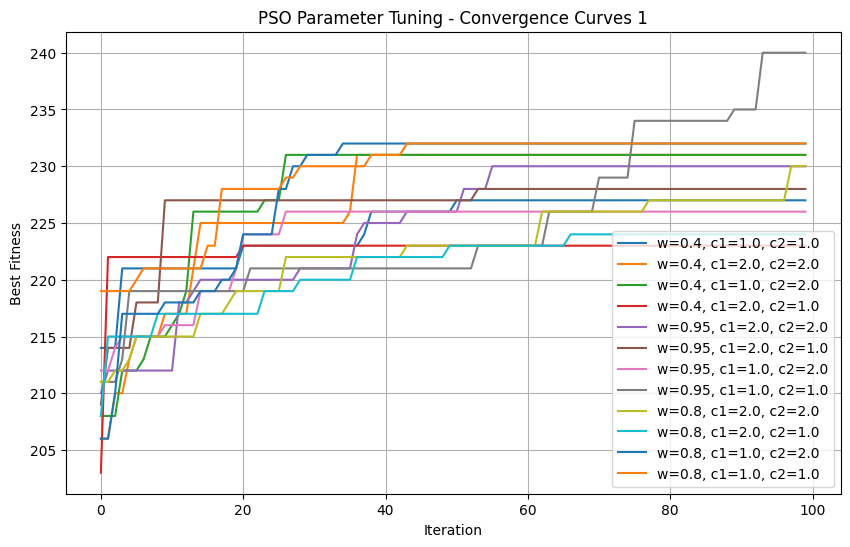

Problem instance loaded: 300 elements, 3000 subsets
Selecting k = 18 subsets


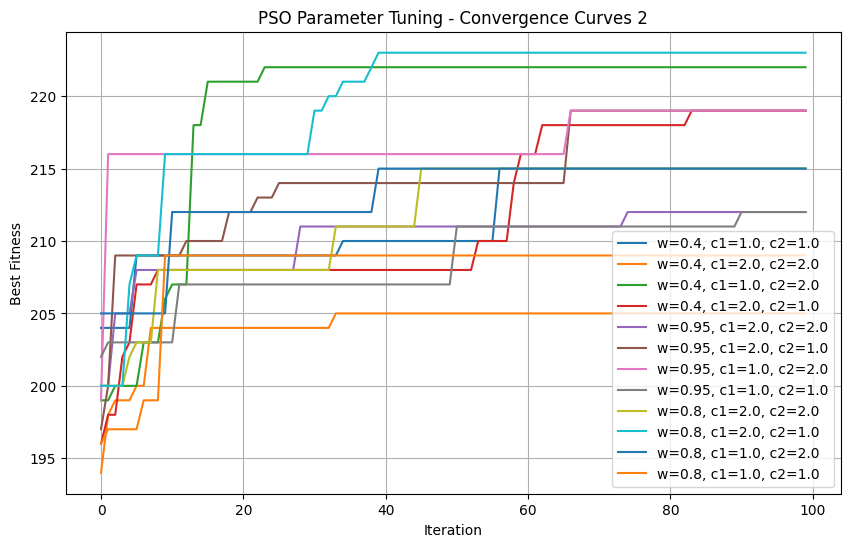

Problem instance loaded: 400 elements, 4000 subsets
Selecting k = 44 subsets


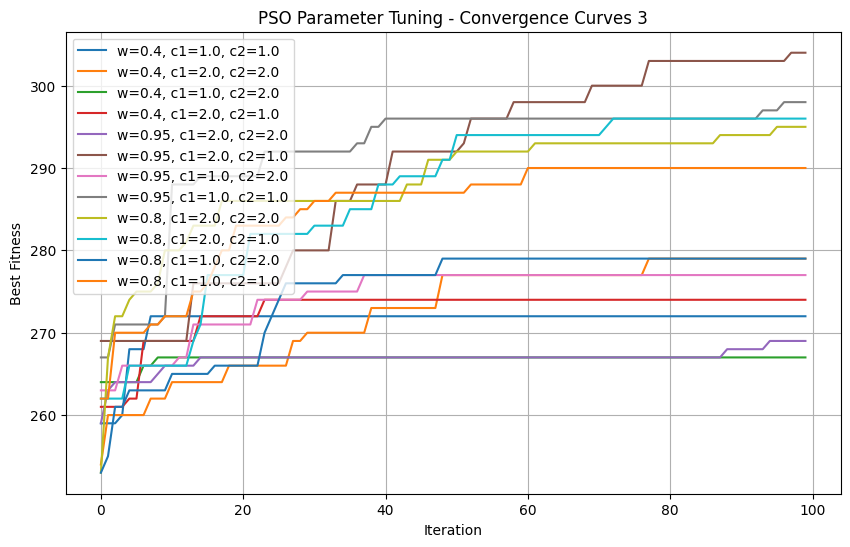

In [120]:

parameter_tuning_experiment(universea1,subsetsa1 , "1",len(subsetsa1)//60) 
parameter_tuning_experiment(universeb2,subsetsb2 , "2",len(subsetsb2)//160) 
parameter_tuning_experiment(universec3,subsetsc3 , "3",len(subsetsc3)//90) 

def print_results(sol1, sol2, sol3,  u1, u2, u3 ):
    """Helper function to print all results"""
    print("\n=== Final Results ===")
    print(f"1. Covered {sol1['fitness']}/{len(u1)} elements")
    print(f"2. Covered {sol2['fitness']}/{len(u2)} elements")
    print(f"3. Covered {sol3['fitness']}/{len(u3)} elements")
   

In [15]:
def test(universe, subsets,filename, k, w, c1, c2):
    
    
    # Problem setup
    problem = MaximumCoveringProblem(universe, subsets, k)
    print(f"\nAnalyzing {filename}:")
    print(f"Problem loaded: {len(universe)} elements, {len(subsets)} subsets, selecting k={k} subsets")
    
    # Run PSO optimization
    pso = DiscretePSO(problem, num_particles=80, max_iter=100, w=w, c1=c1, c2=c2)
    best_solution, convergence = pso.optimize()
    
    # Print results
    print(f"Best solution for {filename}: {best_solution['fitness']} elements covered "
          f"({best_solution['fitness']/len(universe)*100:.2f}% coverage)")
    
    # Plot convergence
    plt.subplot(2, 2, 1)
    plt.plot(convergence)
    plt.title(f"Coverage Convergence - {filename}")
    plt.xlabel("Iteration")
    plt.ylabel("Elements Covered")
    plt.grid(True)
    
    # Add additional visualizations if needed
    # plt.subplot(2, 2, 2) ... etc
    
    plt.tight_layout()
    plt.show()
    
    return best_solution, convergence
    


    

-----TEST A-----

Analyzing Problem_set_a/scpa1.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for Problem_set_a/scpa1.txt: 220 elements covered (73.33% coverage)


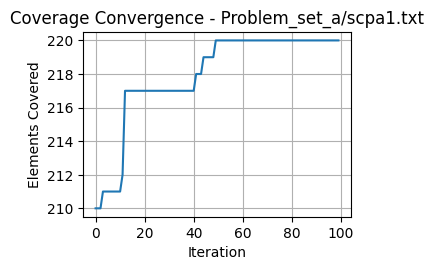


Analyzing Problem_set_a/scpa2.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for Problem_set_a/scpa2.txt: 219 elements covered (73.00% coverage)


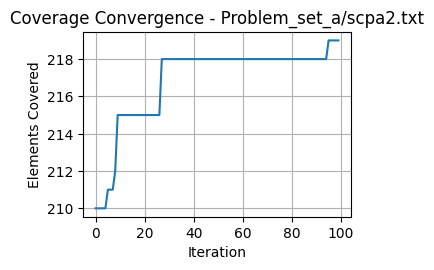


Analyzing Problem_set_a/scpa3.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for Problem_set_a/scpa3.txt: 231 elements covered (77.00% coverage)


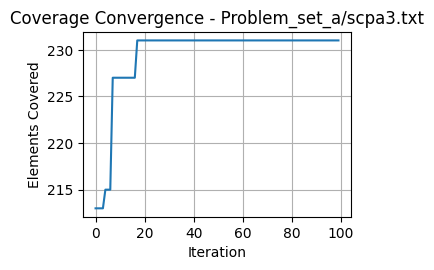


Analyzing Problem_set_a/scpa4.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for Problem_set_a/scpa4.txt: 227 elements covered (75.67% coverage)


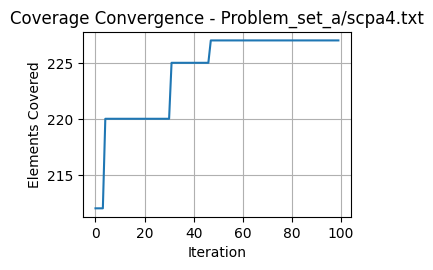


Analyzing Problem_set_a/scpa5.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=50 subsets
Best solution for Problem_set_a/scpa5.txt: 227 elements covered (75.67% coverage)


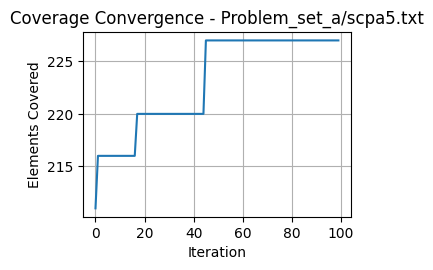

Execution time for Test A: 47.46 seconds


In [16]:
#calculer le temps d'execution de test A
start_time = time()
print("-----TEST A-----")
test(universea1, subsetsa1, "Problem_set_a/scpa1.txt", len(subsetsa1)//60, w=0.95, c1=1.0, c2=1.0)
test(universea2, subsetsa2, "Problem_set_a/scpa2.txt", len(subsetsa1)//60, w=0.95, c1=1.0, c2=1.0)
test(universea3, subsetsa3, "Problem_set_a/scpa3.txt", len(subsetsa1)//60, w=0.95, c1=1.0, c2=1.0)
test(universea4, subsetsa4, "Problem_set_a/scpa4.txt", len(subsetsa1)//60, w=0.95, c1=1.0, c2=1.0)
test(universea5, subsetsa5, "Problem_set_a/scpa5.txt", len(subsetsa1)//60, w=0.95, c1=1.0, c2=1.0)
end_time = time()
#ajouter le calcule dans un vecteur pour l'utiliser apres dans le plot
execution_time_a = end_time - start_time
print(f"Execution time for Test A: {execution_time_a:.2f} seconds")


-----TEST B-----

Analyzing Problem_set_b/scpb1.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=18 subsets
Best solution for Problem_set_b/scpb1.txt: 224 elements covered (74.67% coverage)


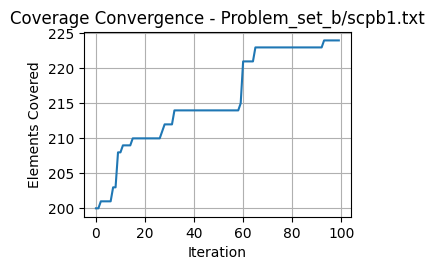


Analyzing Problem_set_b/scpb2.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=18 subsets
Best solution for Problem_set_b/scpb2.txt: 217 elements covered (72.33% coverage)


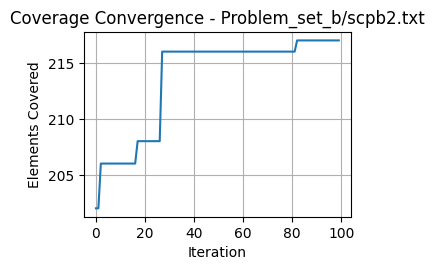


Analyzing Problem_set_b/scpb3.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=18 subsets
Best solution for Problem_set_b/scpb3.txt: 222 elements covered (74.00% coverage)


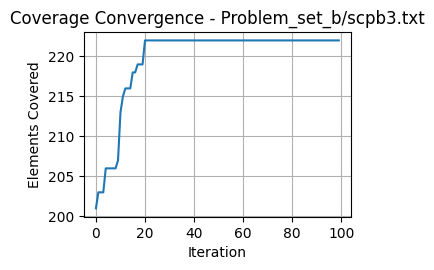


Analyzing Problem_set_b/scpb4.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=18 subsets
Best solution for Problem_set_b/scpb4.txt: 234 elements covered (78.00% coverage)


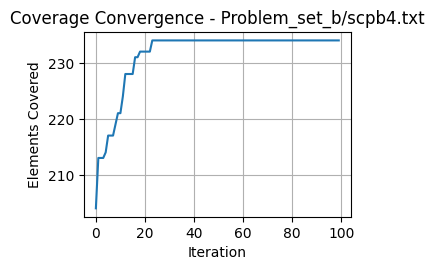


Analyzing Problem_set_b/scpb5.txt:
Problem loaded: 300 elements, 3000 subsets, selecting k=18 subsets
Best solution for Problem_set_b/scpb5.txt: 237 elements covered (79.00% coverage)


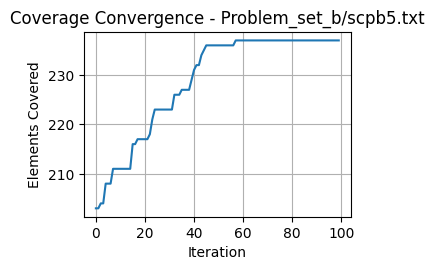

({'position': array([0.74439366, 0.69469058, 0.26830233, ..., 0.2461213 , 0.5584443 ,
         0.51764715]),
  'binary_solution': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [130]:
print("-----TEST B-----")
# test B
test(universeb1, subsetsb1, "Problem_set_b/scpb1.txt", len(subsetsb1)//160, w=0.8, c1=2.0, c2=1.0)
test(universeb2, subsetsb2, "Problem_set_b/scpb2.txt", len(subsetsb1)//160, w=0.8, c1=2.0, c2=1.0)
test(universeb3, subsetsb3, "Problem_set_b/scpb3.txt", len(subsetsb1)//160, w=0.8, c1=2.0, c2=1.0)
test(universeb4, subsetsb4, "Problem_set_b/scpb4.txt", len(subsetsb1)//160, w=0.8, c1=2.0, c2=1.0)
test(universeb5, subsetsb5, "Problem_set_b/scpb5.txt", len(subsetsb1)//160, w=0.8, c1=2.0, c2=1.0)

-----TEST C-----

Analyzing Problem_set_c/scpc1.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=44 subsets
Best solution for Problem_set_c/scpc1.txt: 275 elements covered (68.75% coverage)


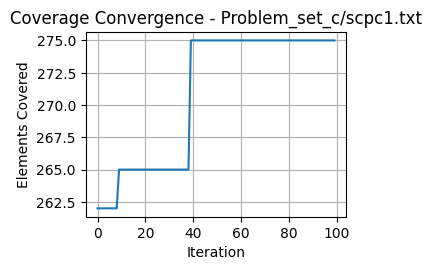


Analyzing Problem_set_c/scpc2.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=44 subsets
Best solution for Problem_set_c/scpc2.txt: 285 elements covered (71.25% coverage)


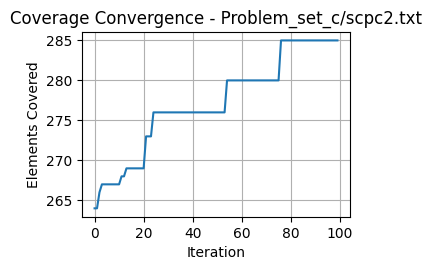


Analyzing Problem_set_c/scpc3.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=44 subsets
Best solution for Problem_set_c/scpc3.txt: 303 elements covered (75.75% coverage)


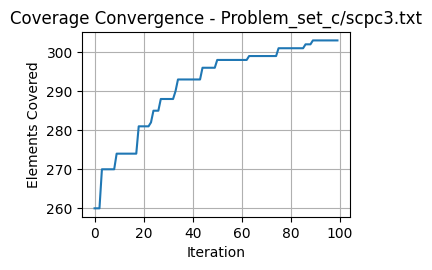


Analyzing Problem_set_c/scpc4.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=44 subsets
Best solution for Problem_set_c/scpc4.txt: 279 elements covered (69.75% coverage)


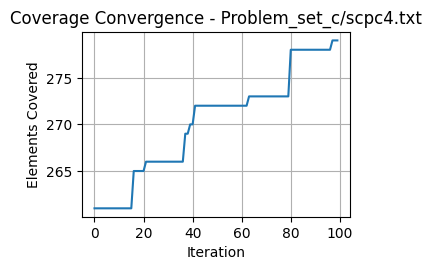


Analyzing Problem_set_c/scpc5.txt:
Problem loaded: 400 elements, 4000 subsets, selecting k=44 subsets
Best solution for Problem_set_c/scpc5.txt: 288 elements covered (72.00% coverage)


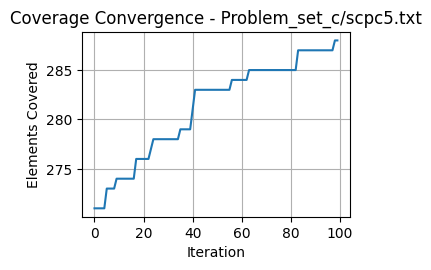

({'position': array([0.77555176, 0.49102024, 0.68441188, ..., 0.02367796, 0.26074556,
         0.38249156]),
  'binary_solution': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
  

In [131]:
print("-----TEST C-----")
# test c
test(universec1, subsetsc1, "Problem_set_c/scpc1.txt", len(subsetsc1)//90, w=0.95, c1=2.0, c2=1.0)
test(universec2, subsetsc2, "Problem_set_c/scpc2.txt", len(subsetsc1)//90, w=0.95, c1=2.0, c2=1.0)
test(universec3, subsetsc3, "Problem_set_c/scpc3.txt", len(subsetsc1)//90, w=0.95, c1=2.0, c2=1.0)
test(universec4, subsetsc4, "Problem_set_c/scpc4.txt", len(subsetsc1)//90, w=0.95, c1=2.0, c2=1.0)
test(universec5, subsetsc5, "Problem_set_c/scpc5.txt", len(subsetsc1)//90, w=0.95, c1=2.0, c2=1.0)

In [ ]:
#executer les fichiers de dossier Problem_set_a avec dfs de MaximumCoveringProblem class
def execute_dfs(universe, subsets, k):
    problem = MaximumCoveringProblem(universe, subsets, k)
    best_solution, best_coverage = problem.solve_with_DFS()
    return best_solution, best_coverage


In [ ]:
#------TEST A DFS------
best_solution_a1, best_coverage_a1 = execute_dfs(universea1, subsetsa1, len(subsetsa1)//60)
best_solution_a2, best_coverage_a2 = execute_dfs(universea2, subsetsa2, len(subsetsa1)//60)
best_solution_a3, best_coverage_a3 = execute_dfs(universea3, subsetsa3, len(subsetsa1)//60)
best_solution_a4, best_coverage_a4 = execute_dfs(universea4, subsetsa4, len(subsetsa1)//60)
best_solution_a5, best_coverage_a5 = execute_dfs(universea5, subsetsa5, len(subsetsa1)//60)

